# Relapse

**This notebook will reproduce all of the bulk deconvolution analysis for Figure 3**

In [1]:
import sys 
%load_ext rpy2.ipython

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline
import copy
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import scipy
import seaborn as sns
sc.set_figure_params(scanpy=True, dpi_save=200)

In /Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/andyzeng/opt/anaconda3

In [2]:
%%R -w 8 -h 4 --units in -r 200
#require("survival")
library(tidyverse)
library(ggpubr)
library(ggsci)

#library(survminer)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# Process Fractions

In [3]:
# load fractions
def load_fractions(dem_path):
    # load CIBERSORT output
    dat = sc.read_csv(dem_path, first_column_names=True)
    dat = dat[:,~dat.var_names.isin(['P-value', 'Correlation', 'RMSE', 'Absolute score (sig.score)'])]
    dat.obs.index.rename('Sample', inplace=True)

    # Absolute Scores
    absolute_scores = dat.to_df()
    absolute_scores.columns = absolute_scores.columns+'-Absolute'
    dat.obs = dat.obs.merge(absolute_scores, how = 'left', left_index=True, right_index=True)
    
    # Relative Scores (tumor only)
    relative_scores = dat.to_df()
    relative_scores = relative_scores.iloc[:,~relative_scores.columns.isin(['B', 'Plasma', 'T', 'CTL', 'NK', 'cDC', 'Monocyte', 'lateEry'])]
    relative_scores = (relative_scores.transpose() / relative_scores.sum(axis=1).transpose()).transpose()
    relative_scores.columns = relative_scores.columns+'-Relative'
    dat.obs = dat.obs.merge(relative_scores, how = 'left', left_index=True, right_index=True)
    
    return dat

In [4]:
# Shlush CIBERSORT Results
shlush = load_fractions("Data/Fig3_Relapse_Deconvolution/CIBERSORTx_DxRx_Shlush_2017.csv")
shlush.obs['Patient'] = [x[0] for x in shlush.obs.index.str.split('_')]
shlush.obs['DxRx'] = [x[2] for x in shlush.obs.index.str.split('_')]

# Normalize malignant proportions 
shlush = shlush[:,shlush.var_names.isin(['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like'])]
shlush.X = (shlush.X.transpose() / shlush.X.sum(axis=1)).transpose()
shlush = shlush[~shlush.obs.Patient.isin(['LDXRX0007'])]
shlush

View of AnnData object with n_obs × n_vars = 22 × 7
    obs: 'B-Absolute', 'CTL-Absolute', 'GMP-like-Absolute', 'LSPC-Cycle-Absolute', 'LSPC-Primed-Absolute', 'LSPC-Quiescent-Absolute', 'Mono-like-Absolute', 'Monocyte-Absolute', 'NK-Absolute', 'Plasma-Absolute', 'ProMono-like-Absolute', 'T-Absolute', 'cDC-Absolute', 'cDC-like-Absolute', 'GMP-like-Relative', 'LSPC-Cycle-Relative', 'LSPC-Primed-Relative', 'LSPC-Quiescent-Relative', 'Mono-like-Relative', 'ProMono-like-Relative', 'cDC-like-Relative', 'Patient', 'DxRx'

In [ ]:
## Label ROp and ROc
#rop_roc = pd.DataFrame({'Patient' : ["LDXRX0003", "LDXRX0006", "LDXRX0004", "LDXRX0009", "LDXRX0008", "LDXRX0002", 
#                                  "LDXRX0010", "LDXRX0015", "LDXRX0012", "LDXRX0001", "LDXRX0011"], 
#                         'Class' : ["ROp", "ROp", "ROp", "ROp", "ROc", "ROc", "ROc", "ROc", "ROc", "ROc", "ROc"]})
#dxrx.obs = dxrx.obs.reset_index().merge(rop_roc, how='left', left_on='Patient', right_on='Patient', left_index=True).set_index('Sample')

In [5]:
## Li CIBERSORT Results
li = load_fractions("Data/Fig3_Relapse_Deconvolution/CIBERSORTx_DxRx_Li_2016.csv")
li.obs['Patient'] = [x[0] + "_" + x[1] for x in li.obs.index.str.split('_')]
li.obs['DxRx'] = [x[2] for x in li.obs.index.str.split('_')]

# Normalize malignant proportions 
li = li[:,li.var_names.isin(['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like'])]
li.X = (li.X.transpose() / li.X.sum(axis=1)).transpose()
li

View of AnnData object with n_obs × n_vars = 38 × 7
    obs: 'B-Absolute', 'CTL-Absolute', 'GMP-like-Absolute', 'LSPC-Cycle-Absolute', 'LSPC-Primed-Absolute', 'LSPC-Quiescent-Absolute', 'Mono-like-Absolute', 'Monocyte-Absolute', 'NK-Absolute', 'Plasma-Absolute', 'ProMono-like-Absolute', 'T-Absolute', 'cDC-Absolute', 'cDC-like-Absolute', 'GMP-like-Relative', 'LSPC-Cycle-Relative', 'LSPC-Primed-Relative', 'LSPC-Quiescent-Relative', 'Mono-like-Relative', 'ProMono-like-Relative', 'cDC-like-Relative', 'Patient', 'DxRx'

In [6]:
## Christopher CIBERSORT Results - Chemo DxRx
christopher = load_fractions("Data/Fig3_Relapse_Deconvolution/CIBERSORTx_DxRx_Christopher_2018.csv")
christopher.obs['Patient'] = [x[0] for x in christopher.obs.index.str.split('.')]
christopher.obs['Status'] = [x[1] for x in christopher.obs.index.str.split('.')]
christopher.obs['DxRx'] = np.where(christopher.obs['Status'] == 'primary', 'Dx', 'Rel')

# Normalize malignant proportions 
christopher = christopher[:,christopher.var_names.isin(['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like'])]
christopher.X = (christopher.X.transpose() / christopher.X.sum(axis=1)).transpose()

# Filter out post-allo HSCT
christopher = christopher[christopher.obs['Patient'].isin(['112200', '150288', '196371', '220882', '286032', '303642', '327733', '452198', '593890'])]
christopher = christopher[christopher.obs.index != '452198.post_allo']
christopher

View of AnnData object with n_obs × n_vars = 18 × 7
    obs: 'B-Absolute', 'CTL-Absolute', 'GMP-like-Absolute', 'LSPC-Cycle-Absolute', 'LSPC-Primed-Absolute', 'LSPC-Quiescent-Absolute', 'Mono-like-Absolute', 'Monocyte-Absolute', 'NK-Absolute', 'Plasma-Absolute', 'ProMono-like-Absolute', 'T-Absolute', 'cDC-Absolute', 'cDC-like-Absolute', 'GMP-like-Relative', 'LSPC-Cycle-Relative', 'LSPC-Primed-Relative', 'LSPC-Quiescent-Relative', 'Mono-like-Relative', 'ProMono-like-Relative', 'cDC-like-Relative', 'Patient', 'Status', 'DxRx'

In [9]:
## Cocciardi CIBERSORT Results - NPM1mut Chemo DxRx
cocciardi = load_fractions("Data/Fig3_Relapse_Deconvolution/CIBERSORTx_DxRx_Cocciardi_2019.csv")
cocciardi.obs.index.rename('Sample', inplace=True)
cocciardi.obs['Patient'] = [x[0] for x in cocciardi.obs.index.str.split('_')]
cocciardi.obs['Status'] = [x[1] for x in cocciardi.obs.index.str.split('_')]
cocciardi.obs['Class'] = [x[2] for x in cocciardi.obs.index.str.split('_')]
cocciardi.obs['DxRx'] = np.where(cocciardi.obs['Status'] == 'dx', 'Dx', 'Rel')

# Normalize malignant proportions
cocciardi = cocciardi[:,cocciardi.var_names.isin(['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like'])]
cocciardi.X = (cocciardi.X.transpose() / cocciardi.X.sum(axis=1)).transpose()

# Remove "NPM1 lost" samples - these are not true relapse but in fact a second de novo AML 
cocciardi = cocciardi[cocciardi.obs.Class == 'NPM1kept']
cocciardi

View of AnnData object with n_obs × n_vars = 10 × 7
    obs: 'B-Absolute', 'CTL-Absolute', 'GMP-like-Absolute', 'LSPC-Cycle-Absolute', 'LSPC-Primed-Absolute', 'LSPC-Quiescent-Absolute', 'Mono-like-Absolute', 'Monocyte-Absolute', 'NK-Absolute', 'Plasma-Absolute', 'ProMono-like-Absolute', 'T-Absolute', 'cDC-Absolute', 'cDC-like-Absolute', 'GMP-like-Relative', 'LSPC-Cycle-Relative', 'LSPC-Primed-Relative', 'LSPC-Quiescent-Relative', 'Mono-like-Relative', 'ProMono-like-Relative', 'cDC-like-Relative', 'Patient', 'Status', 'Class', 'DxRx'

# Paired Wilcoxon Test from Diagnosis to Relapse

In [11]:
def paired_scores(df, dat, pt_id, label, group, groupA, groupB):
    from scipy.stats import wilcoxon
    pairs = dat.obs[[pt_id, group]+dat.obs.columns[dat.obs.columns.str.contains('Relative')].tolist()].pivot(index=pt_id, columns=group).dropna()
    #pairs[['positive']] - pairs['negative']
    for celltype in dat.obs.columns[dat.obs.columns.str.contains('Relative')].tolist(): 
        w,p = wilcoxon(pairs[celltype][groupA] - pairs[celltype][groupB])
        lfc = np.log(np.mean(pairs[celltype][groupA]) / np.mean(pairs[celltype][groupB]))
        df = df.append(pd.DataFrame({"names":[celltype], 'logfoldchanges':[lfc], 'pvals':[p], 'Status':[label], 'Test':['wilcox paired']}))

    return(df)

In [12]:
df = pd.DataFrame()

In [13]:
df = paired_scores(df, shlush, 'Patient', 'Shlush', 'DxRx', 'Rel', 'Dx')
df.tail(7)

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,names,logfoldchanges,pvals,Status,Test
0,GMP-like-Relative,-0.164978,0.464844,Shlush,wilcox paired
0,LSPC-Cycle-Relative,0.257959,0.174805,Shlush,wilcox paired
0,LSPC-Primed-Relative,0.162559,0.147461,Shlush,wilcox paired
0,LSPC-Quiescent-Relative,0.685310,0.041992,Shlush,wilcox paired
0,Mono-like-Relative,-1.396279,0.032227,Shlush,wilcox paired
0,ProMono-like-Relative,2.104268,0.043114,Shlush,wilcox paired
0,cDC-like-Relative,-0.076592,0.320312,Shlush,wilcox paired


In [14]:
df = paired_scores(df, li, 'Patient', 'Li', 'DxRx', 'Rel', 'Dx')
df.tail(7)

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,names,logfoldchanges,pvals,Status,Test
0,GMP-like-Relative,-0.246786,0.312408,Li,wilcox paired
0,LSPC-Cycle-Relative,0.740696,0.015972,Li,wilcox paired
0,LSPC-Primed-Relative,0.429850,0.039474,Li,wilcox paired
0,LSPC-Quiescent-Relative,1.008126,0.001002,Li,wilcox paired
0,Mono-like-Relative,-1.605383,0.004439,Li,wilcox paired
0,ProMono-like-Relative,-0.863100,0.000645,Li,wilcox paired
0,cDC-like-Relative,-0.280387,0.044559,Li,wilcox paired


In [15]:
df = paired_scores(df, christopher, 'Patient', 'Christopher', 'DxRx', 'Rel', 'Dx')
df.tail(7)

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,names,logfoldchanges,pvals,Status,Test
0,GMP-like-Relative,-0.364174,0.910156,Christopher,wilcox paired
0,LSPC-Cycle-Relative,0.638971,0.164062,Christopher,wilcox paired
0,LSPC-Primed-Relative,0.362706,0.250000,Christopher,wilcox paired
0,LSPC-Quiescent-Relative,0.852523,0.054688,Christopher,wilcox paired
0,Mono-like-Relative,0.039106,1.000000,Christopher,wilcox paired
0,ProMono-like-Relative,-2.384507,0.062979,Christopher,wilcox paired
0,cDC-like-Relative,-0.284566,0.250000,Christopher,wilcox paired


In [16]:
df = paired_scores(df, cocciardi, 'Patient', 'Cocciardi', 'DxRx', 'Rel', 'Dx')
df.tail(7)

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,names,logfoldchanges,pvals,Status,Test
0,GMP-like-Relative,-0.119702,0.062500,Cocciardi,wilcox paired
0,LSPC-Cycle-Relative,-0.148976,0.312500,Cocciardi,wilcox paired
0,LSPC-Primed-Relative,0.131265,0.187500,Cocciardi,wilcox paired
0,LSPC-Quiescent-Relative,0.848323,0.187500,Cocciardi,wilcox paired
0,Mono-like-Relative,-2.506098,0.062500,Cocciardi,wilcox paired
0,ProMono-like-Relative,1.359326,0.144127,Cocciardi,wilcox paired
0,cDC-like-Relative,-0.080359,0.437500,Cocciardi,wilcox paired


In [17]:
# Get directional log pvalues
df['logPval_dir'] = np.where(df['logfoldchanges'] < 0, np.log(df['pvals']), -np.log(df['pvals']))
df.names = df.names.str.replace('-Relative', '')
# Re-arrange cell types and format logpvalues and raw pvalues
df['CellType'] = df['names'].astype('category').cat.set_categories(['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like'])
df_logpval_dir = df.pivot(index='Status', columns='names', values='logPval_dir')[['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']].T
df_pvalue = df.pivot(index='Status', columns='names', values='pvals')[['LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like']].T

In [18]:
# Re-order the studies by principal component 1
df_drug_clust = ad.AnnData((df_pvalue < 0.05) * df_logpval_dir).T
sc.pp.pca(df_drug_clust, n_comps=1)
df_drug_clust.obs['pc1'] = df_drug_clust.obsm['X_pca'].flatten()
df_logpval_dir = df_logpval_dir[df_drug_clust.obs.sort_values('pc1', ascending=False).index.values]
df_pvalue = df_pvalue[df_drug_clust.obs.sort_values('pc1', ascending=False).index.values]

R[write to console]: corrplot 0.90 loaded



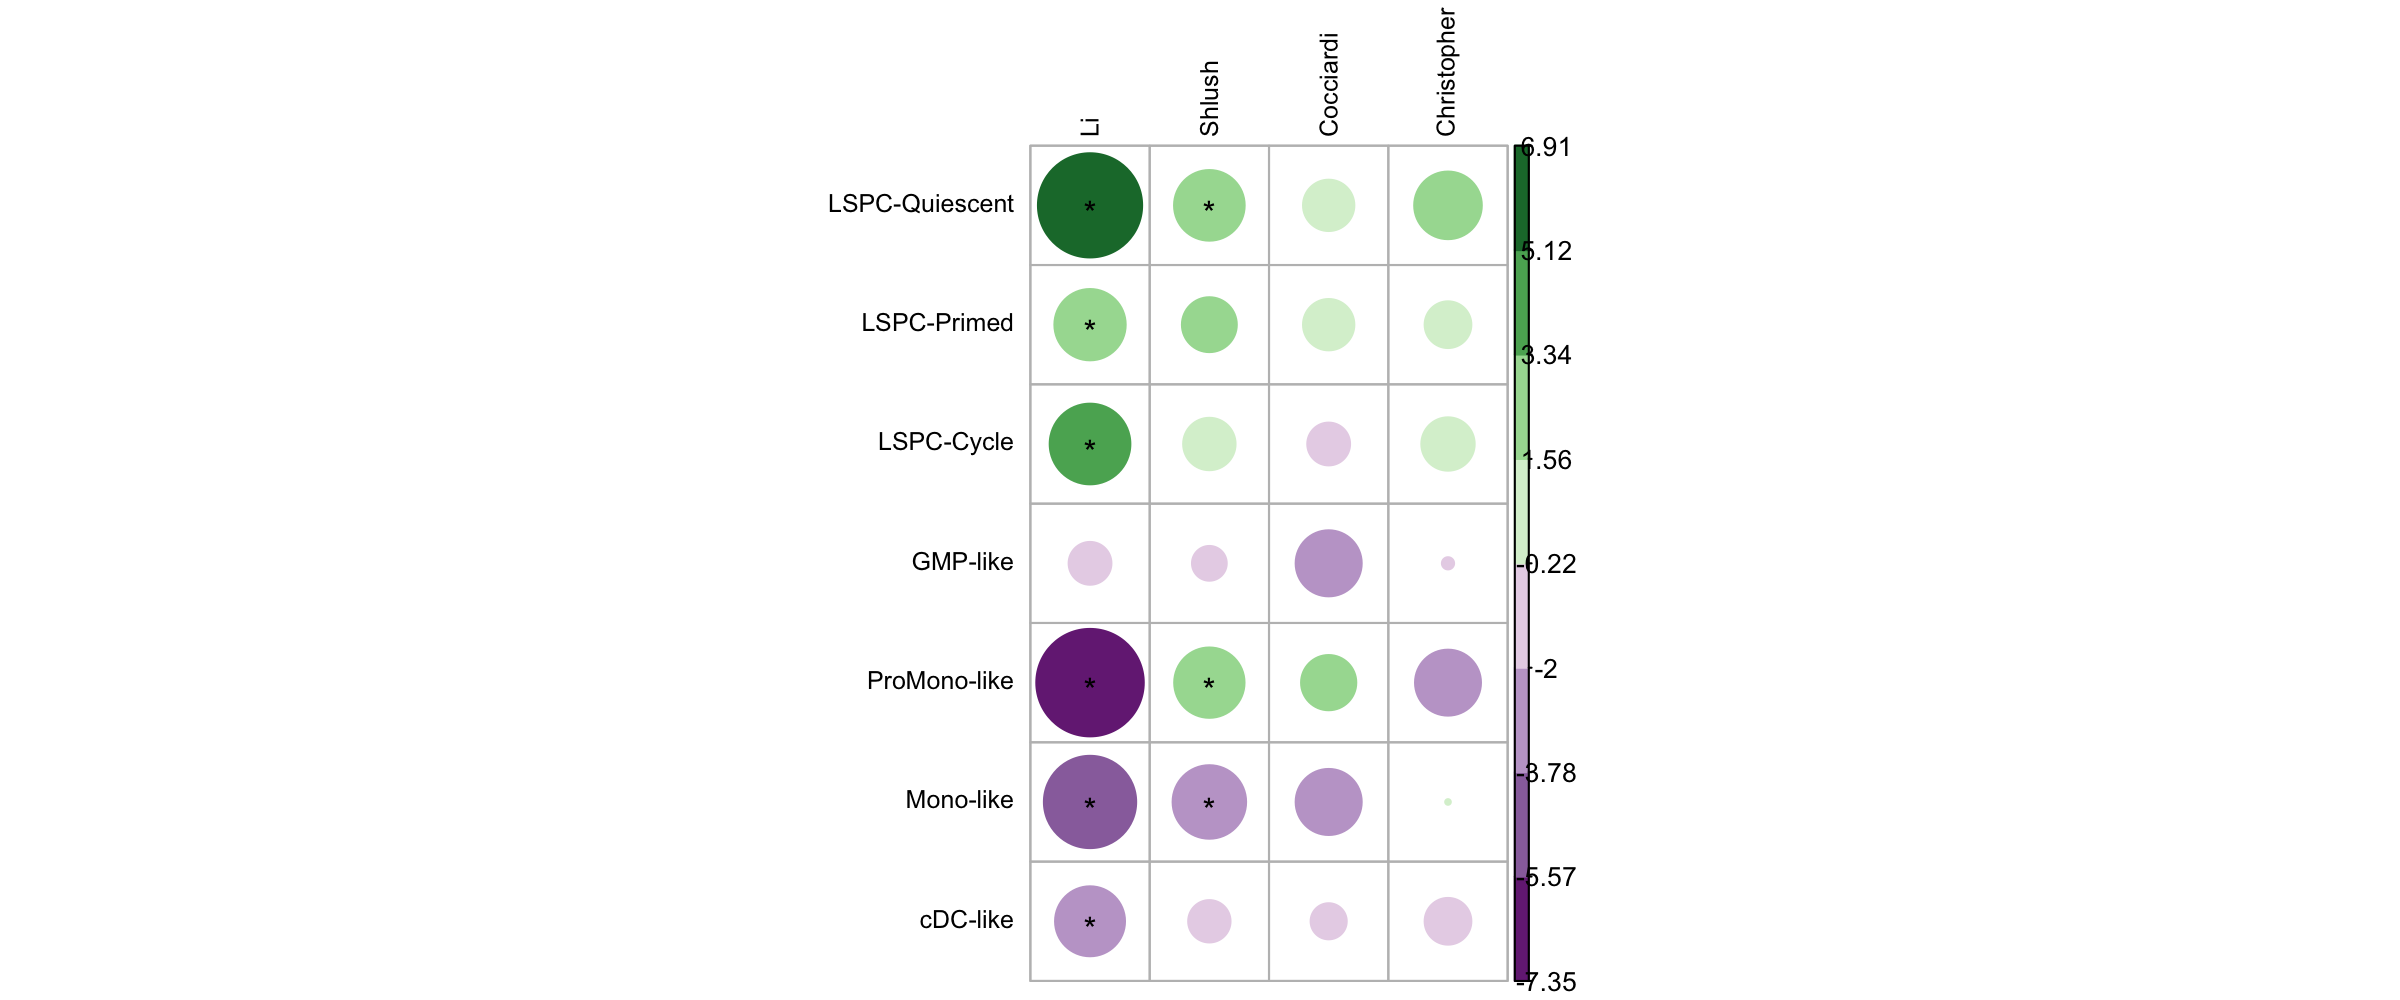

In [19]:
%%R -w 12 -h 5 --units in -r 200 -i df_logpval_dir -i df_pvalue

library("corrplot")
library(RColorBrewer)


df_logpval_dir %>% data.matrix() %>% corrplot(method = "circle", tl.cex=0.75, p.mat = data.matrix(df_pvalue),
                                        sig.level=0.05, insig = "label_sig", pch.col = "black", pch.cex = 1, 
                                        is.corr = FALSE, tl.col = 'black', col=brewer.pal(8, 'PRGn')) #c("pch", "p-value", "blank", "n", "label_sig"),) 

## Project Hierarchies

In [47]:
# Hierarchy Reference Cohorts
href = sc.read_h5ad('Data/Hierarchy_Reference_3Cohorts.h5ad')
href

AnnData object with n_obs × n_vars = 864 × 7
    obs: 'Cohort', 'Cluster', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'NMF1', 'NMF2', 'NMF3'
    var: 'NMF1', 'NMF2', 'NMF3'
    uns: 'Cluster_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [48]:
# Combine reference cohorts with diagnosis-relapse datasets
dxrx_merged = href.concatenate(shlush, li, christopher, cocciardi, batch_key='Cohort', batch_categories=['href', 'Shlush et al', 'Li et al', 'Christopher et al', 'Cocciardi et al'])
sc.pp.combat(dxrx_merged, key='Cohort')
sc.tl.ingest(dxrx_merged, href, embedding_method='pca', obs='Cluster')
dxrx_merged = dxrx_merged[dxrx_merged.obs.Cohort!='href']

... storing 'Cluster' as categorical
... storing 'Patient' as categorical
... storing 'DxRx' as categorical
... storing 'Status' as categorical
... storing 'Class' as categorical
/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [49]:
# Gather coordinates to project in R
dxrx_merged.obs['PC1'] = dxrx_merged.obsm['X_pca'][:,0]
dxrx_merged.obs['PC2'] = dxrx_merged.obsm['X_pca'][:,1]
combined_dxrx_merged = href.obs[['PC1', 'PC2', 'Cohort']].append(dxrx_merged.obs[['PC1', 'PC2', 'Patient', 'Cluster', 'DxRx', 'Status', 'Cohort',
                                                                                 'GMP-like-Relative', 'LSPC-Cycle-Relative', 'LSPC-Primed-Relative', 'LSPC-Quiescent-Relative', 
                                                                                  'Mono-like-Relative', 'ProMono-like-Relative', 'cDC-like-Relative']])
combined_dxrx_merged[['Patient', 'Cluster', 'DxRx', 'Status']] = combined_dxrx_merged[['Patient', 'Cluster', 'DxRx', 'Status']].fillna('NA')

Trying to set attribute `.obs` of view, copying.


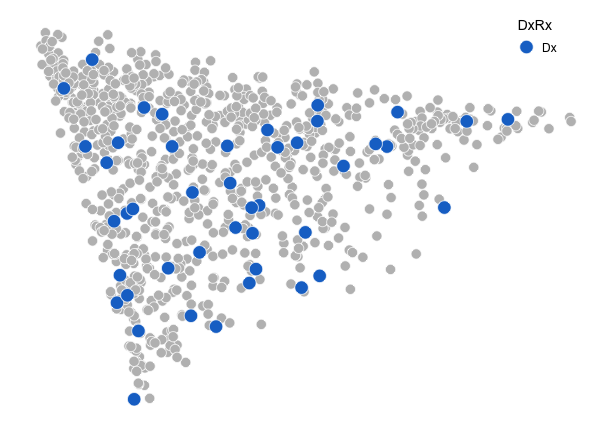

In [50]:
%%R -i combined_dxrx_merged -h 6 -w 8.5 --units in

combined_dxrx_merged %>% 
    ggplot(aes(x = PC1, y = PC2)) + 
    geom_point(data = subset(combined_dxrx_merged, DxRx == 'NA'), size=4.5, shape=21, fill ='grey', color='white') + 
    geom_point(data = subset(combined_dxrx_merged, DxRx == 'Dx'), aes(fill = DxRx), size=6, shape=21, color='white') + 
    scale_fill_manual(values=c('dodgerblue3')) + 
    theme_void() + 
    theme(legend.title = element_text(size = 14), 
          legend.text = element_text(size = 12), 
          legend.position = c(0.93, 0.99),
          legend.justification = c("right", 'top'),
          plot.margin = unit(c(1, 1, 1, 1), "lines"))# + ggsave("figures/DxRx_DxOnly_Hierarchy_linked.png", dpi='retina', height=6, width=8.2)

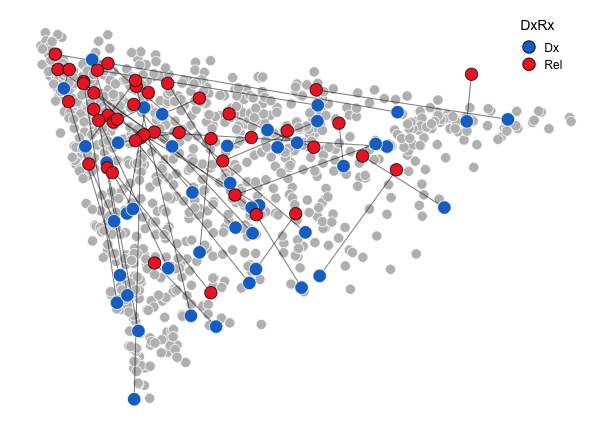

In [51]:
%%R -i combined_dxrx_merged -h 6 -w 8.5 --units in

combined_dxrx_merged %>% 
    ggplot(aes(x = PC1, y = PC2)) + 
    geom_point(data = subset(combined_dxrx_merged, DxRx == 'NA'), size=4.5, shape=21, fill ='grey', color='white') + 
    geom_path(data = subset(combined_dxrx_merged, DxRx != 'NA'), aes(group = Patient), alpha = 0.5) +#, arrow = arrow(type = "closed", length=unit(0.02, "npc"))) + 
    geom_point(data = subset(combined_dxrx_merged, DxRx == 'Dx'), aes(fill = DxRx), size=6, shape=21, color='white') + 
    geom_point(data = subset(combined_dxrx_merged, DxRx == 'Rel'), aes(fill = DxRx), size=5.5, shape=21, color='black') + 
    scale_fill_manual(values=c('dodgerblue3', 'firebrick2')) +
    theme_void() + 
    theme(legend.title = element_text(size = 14), 
          legend.text = element_text(size = 12), 
          legend.position = c(0.94, 0.99),
          legend.justification = c("right", 'top'),
          plot.margin = unit(c(1, 1, 1, 1), "lines")) #+ ggsave("figures/DxRx_All_Hierarchy_linked.png", dpi='retina', height=6, width=8.2)

## Alluvial Plot of Class Switching

`summarise()` has grouped output by 'Dx'. You can override using the `.groups` argument.


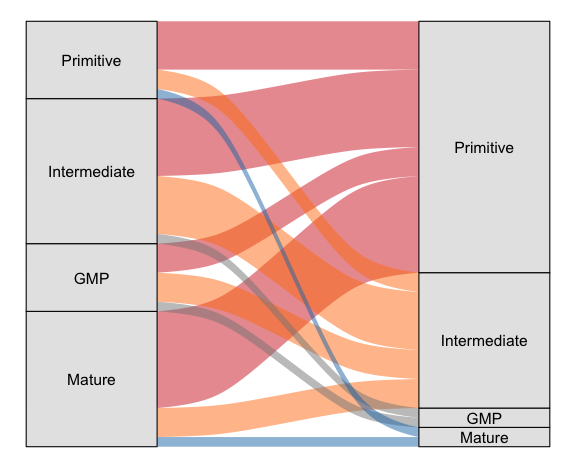

In [55]:
%%R -h 6.5 -w 8 --units in

library(ggalluvial)
colors = c('#d62728', '#ff7f0e', '#868686', '#1f77b4')

combined_dxrx_merged %>% 
    filter(DxRx != 'NA') %>% 
    select(Patient, DxRx, Cluster) %>% 
    spread(DxRx, Cluster) %>% 
    group_by(Dx, Rel) %>% 
    summarise(count = n()) %>% 
    mutate(Dx = factor(Dx, levels=c('Primitive', 'Intermediate', 'GMP', 'Mature'))) %>%
    mutate(Rel = factor(Rel, levels=c('Primitive', 'Intermediate', 'GMP', 'Mature'))) %>%
    ggplot(.,
           aes(axis1 = Dx, axis2 = Rel, y = count)) +
    geom_alluvium(aes(fill = Rel)) +
    geom_stratum(fill='#E5E5E5') +
    geom_text(stat = "stratum",
            aes(label = after_stat(stratum)), size=5.5) +
    scale_fill_manual(values = colors) + 
    theme_void() + 
    theme(legend.position='none')


## Change in LSPCs and PCs based on Hierarchy at Diagnosis

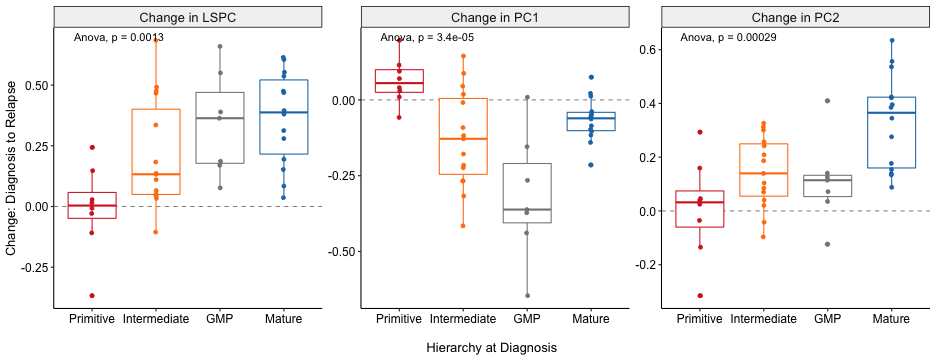

In [56]:
%%R -h 5 -w 13 --units in

colors = c('#d62728', '#ff7f0e', '#868686', '#1f77b4')

combined_dxrx_merged %>% 
    filter(!(Cohort %in% c('TCGA', 'BEAT', 'Leucegene'))) %>% 
    mutate(Cluster = factor(Cluster, levels=c('Primitive', 'Intermediate', 'GMP', 'Mature')), 
           LSPC = `LSPC-Quiescent-Relative` + `LSPC-Primed-Relative` + `LSPC-Cycle-Relative`) %>% 
    group_by(Patient) %>% mutate(`Change in PC1` = PC1-lag(PC1), `Change in PC2` = PC2-lag(PC2), `Change in LSPC` = LSPC - lag(LSPC), DxCluster = lag(Cluster)) %>% 
    filter(DxRx == "Rel") %>% select(Patient, DxCluster, contains('Change')) %>%
    ungroup() %>% select(-Patient) %>% 
    gather(-DxCluster, key='variable', value='value') %>%
    ggplot(aes(x = DxCluster, y = value, color= DxCluster)) +
    geom_hline(yintercept=0, alpha=0.5, linetype='dashed') +
    geom_boxplot() + geom_jitter(width=0.01) +
    facet_wrap(.~variable, scales='free_y') +
    scale_color_manual(values=colors) +
    theme_pubr(legend='none') + 
    ylab('Change: Diagnosis to Relapse') +
    xlab('\nHierarchy at Diagnosis') +
    theme(strip.text.x = element_text(size=13), axis.title.x = element_text(size=13), axis.title.y = element_text(size=13), axis.text.x = element_text(size=12)) +
    stat_compare_means(method='anova')

### Paired changes in individual cell types

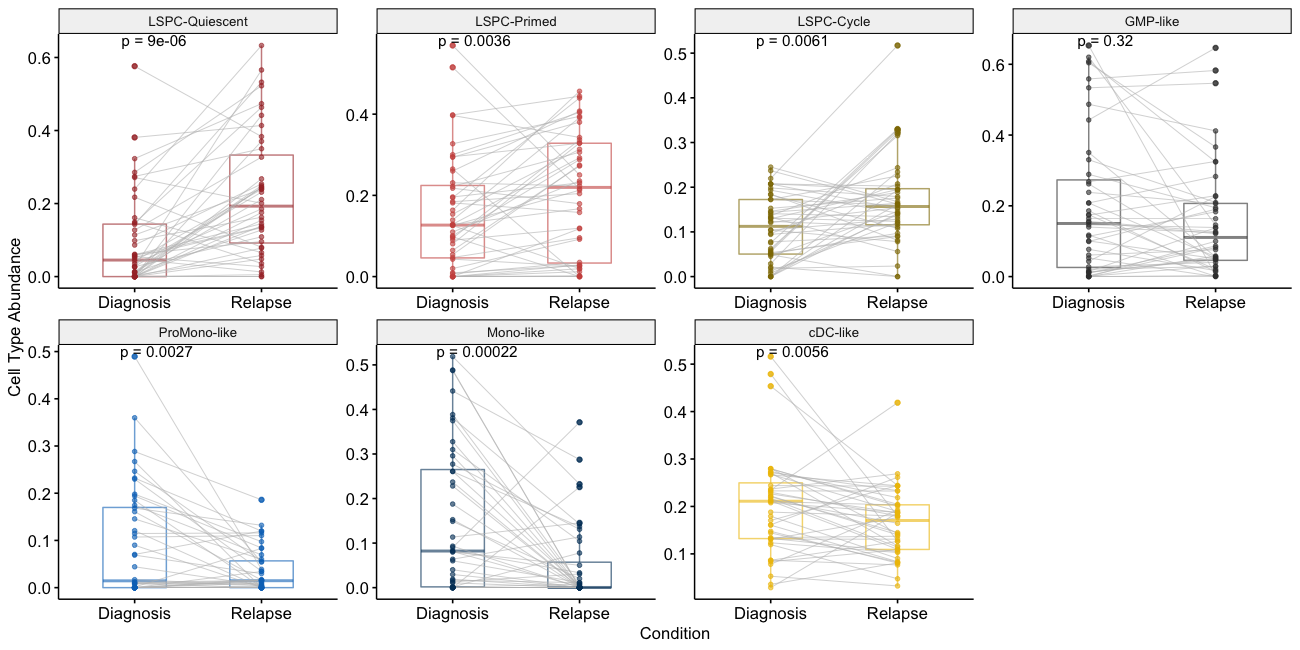

In [57]:
%%R -w 13 -h 6.5 --units in -r 100

hierarchy_colors = c('#A7303099', '#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')

dxrxmerge_obs <- combined_dxrx_merged %>% 
    filter(!(Cohort %in% c('TCGA', 'BEAT', 'Leucegene'))) %>% 
    select(Patient, DxRx, Cluster, contains('Relative')) %>%
    gather(-Patient, -DxRx, -Cluster, key = "CellType", value = "Score") %>% 
    mutate(CellType = CellType %>% str_replace('-Relative', '')) %>% 
    mutate(CellType = factor(CellType, levels=c('LSPC-Quiescent', 'LSPC-Primed', 'LSPC-Cycle', 'GMP-like', 'ProMono-like', 'Mono-like', 'cDC-like')))
    
dxrxmerge_obs %>% 
    mutate(DxRx = ifelse(DxRx=='Dx', 'Diagnosis', 'Relapse')) %>%
    ggpaired(., x = 'DxRx', y = 'Score', color = 'CellType', id = 'Patient', 
            line.color = "gray", line.size = 0.2, short.panel.labs = TRUE, ylab = 'Cell Type Abundance') + theme(legend.position="None") +
    scale_color_manual(values = hierarchy_colors) -> p
p <- p + stat_compare_means(label = "p.format", paired = TRUE)

facet(p,facet.by = c("CellType"), ncol=4, scales = 'free') #+ ggsave("DxRx/Figures/Relapse_comparison_pooled_cube.png", dpi='retina', height=10, width=12)

## Genetic Patterns at Relapse

In NPM1 mutant AML, FLT3-ITD is recurrently gained at relapse while FLT3-TKD and NRAS are recurrently lost. 
Are there differences in the hierarchies generated through FLT3-ITD compared to NRAS + FLT3-TKD on a background of NPM1? 

Here I am looking at the hierarchies of diagnostic AML patients with NPM1 + FLT3-ITD compared to those with NPM1 + FLT3-TKD / NPM1 + NRAS. 
Note that there is no VAF filter here but the results are consistent with a VAF cutoff of 0.25 (just fewer patients captured due to missing data)

In [59]:
genomics = pd.read_csv('Data/Cohort_Combined_Cytogenetics_Mutations_Feb16.csv').set_index('Patient')
genomics.head()

,Cohort,Age,FAB,Cytogenetic risk,Normal Karyotype,ELN2017,inv(3): GATA2/MECOM,t(11q23): MLL_Fusion,t(9;22): BCR-ABL,t(5;11): NUP98-NSD1,...,SMC1A_VAF,SMC3_VAF,SPI1_VAF,SRSF2_VAF,STAG2_VAF,TET2_VAF,TP53_VAF,U2AF1_VAF,WT1_VAF,ZRSR2_VAF
Patient,,,,,,,,,,,,,,,,,,,,,
12-00023,BEAT,71.0,NaN,Intermediate,Normal Karyotype,Intermediate,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.24,0.0
12-00051,BEAT,55.0,NaN,Intermediate,Normal Karyotype,FavorableOrIntermediate,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.80,0.0
12-00066,BEAT,70.0,NaN,Intermediate,Normal Karyotype,Intermediate,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.00,0.0
12-00211,BEAT,50.0,NaN,NaN,Other,Favorable,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.50,0.0
12-00294,BEAT,72.0,NaN,Intermediate,Normal Karyotype,Adverse,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [61]:
npm1_flt3_nras = href.obs.join(genomics.drop('Cohort', axis=1))[['PC1', 'PC2', 'NPM1_mut', 'FLT3-ITD_mut', 'FLT3_TKD', 'NRAS_mut', 'KRAS_mut']].fillna('NA')
npm1_flt3_nras

,PC1,PC2,NPM1_mut,FLT3-ITD_mut,FLT3_TKD,NRAS_mut,KRAS_mut
TCGA-AB-2803,0.315948,0.053389,NA,NA,NA,NA,NA
TCGA-AB-2805,-0.166651,-0.351056,Negative,Negative,NA,Negative,Negative
TCGA-AB-2806,0.477078,0.107512,NA,NA,NA,NA,NA
TCGA-AB-2807,-0.254393,0.088499,Negative,Negative,NA,Negative,Negative
TCGA-AB-2808,0.060838,-0.057681,Negative,Negative,NA,Positive,Negative
...,...,...,...,...,...,...,...
14H020,0.216257,0.176750,NA,NA,NA,NA,NA
14H023,-0.200947,0.086947,NA,NA,NA,NA,NA
14H027,-0.213478,0.109488,NA,NA,NA,NA,NA
14H031,-0.146454,-0.232116,Negative,Negative,NA,Positive,Positive


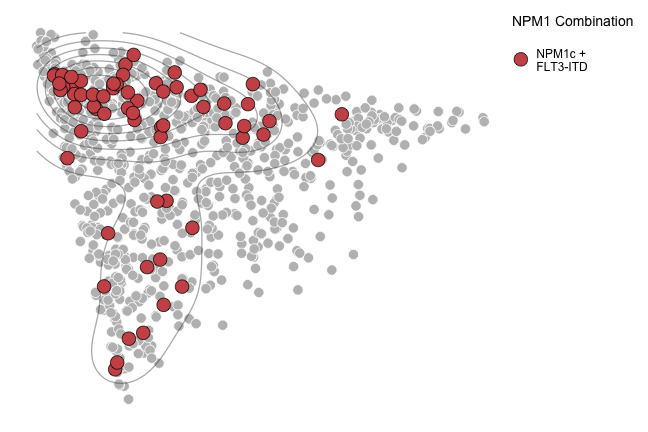

In [63]:
%%R -i npm1_flt3_nras -h 6 -w 9 --units in

npm1_flt3_nras <- npm1_flt3_nras %>% mutate(NPM1_combo = if_else(NPM1_mut == "Positive",
                                                                 if_else((`FLT3-ITD_mut` == 'Positive'), '\nNPM1c +\nFLT3-ITD\n', 'NA'), 'NA'))

npm1_flt3_nras %>% 
    ggplot(aes(x = PC1, y = PC2)) + 
    geom_point(data = subset(npm1_flt3_nras, `NPM1_combo` == 'NA'), size=4.5, shape=21, fill ='grey', color='white') + 
    stat_density_2d(data = subset(npm1_flt3_nras, `NPM1_combo` == '\nNPM1c +\nFLT3-ITD\n'), alpha=0.4, size=0.6, color='grey20', h=0.3) + 
    geom_point(data = subset(npm1_flt3_nras, `NPM1_combo` == '\nNPM1c +\nFLT3-ITD\n'), aes(fill = `NPM1_combo`), size=6, shape=21, color='black') + 
    scale_fill_manual(values = c('indianred3')) + 
    #scale_fill_brewer(palette='Dark2') + 
    #scale_fill_aaas() + 
    theme_void() + 
    labs(fill = "NPM1 Combination") +
    theme(legend.title = element_text(size = 14), 
          legend.text = element_text(size = 12), 
          legend.justification = "top", 
          plot.margin = unit(c(1, 1, 1, 1), "lines"))

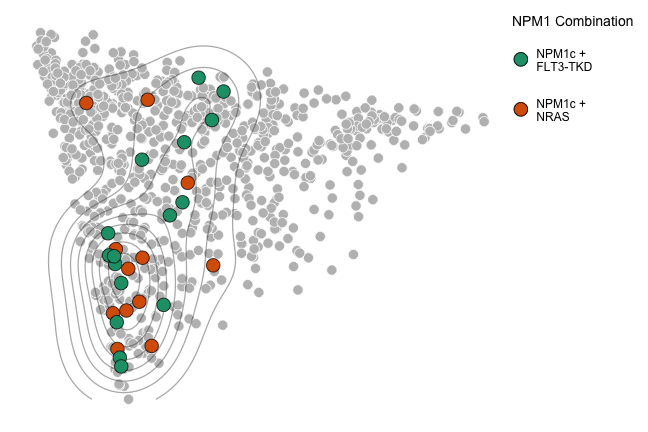

In [64]:
%%R -i npm1_flt3_nras -h 6 -w 9 --units in

npm1_flt3_nras <- npm1_flt3_nras %>% mutate(NPM1_combo = if_else(NPM1_mut == "Positive", 
                                                                 if_else((`NRAS_mut` == 'Positive'), '\nNPM1c +\nNRAS\n',
                                                                         if_else(`FLT3_TKD` == 'Positive', '\nNPM1c +\nFLT3-TKD\n', 'NA')), 'NA'))

npm1_flt3_nras %>% 
    ggplot(aes(x = PC1, y = PC2)) + 
    geom_point(data = subset(npm1_flt3_nras, `NPM1_combo` == 'NA'), size=4.5, shape=21, fill ='grey', color='white') + 
    #geom_point(data = subset(newcat_obs, `NPM1_combo` == '\nNPM1 only\n'), aes(fill = `NPM1_combo`), size=5.2, shape=21, color='white') + 
    geom_density_2d(data = subset(npm1_flt3_nras, `NPM1_combo` != 'NA'), size=0.6, alpha=0.4, color='grey20', h=0.3) + 
    geom_point(data = subset(npm1_flt3_nras, `NPM1_combo` == '\nNPM1c +\nNRAS\n'), aes(fill = `NPM1_combo`), size=6, shape=21, color='black') + 
    geom_point(data = subset(npm1_flt3_nras, `NPM1_combo` == '\nNPM1c +\nFLT3-TKD\n'), aes(fill = `NPM1_combo`), size=6, shape=21, color='black') + 
    #geom_point(data = subset(newcat_obs, `NPM1_combo` == '\nNPM1c +\nPTPN11\n'), aes(fill = `NPM1_combo`), size=5.2, shape=21, color='black') + 
    #scale_fill_manual(values = c('dodgerblue2', 'firebrick2')) + 
    scale_fill_brewer(palette='Dark2') + 
    #scale_fill_aaas() + 
    theme_void() + 
    labs(fill = "NPM1 Combination") +
    theme(legend.title = element_text(size = 14), 
          legend.text = element_text(size = 12), 
          legend.justification = "top", 
          plot.margin = unit(c(1, 1, 1, 1), "lines"))

## Clonal Evolution

Can evolution in cellular hierarchies from diagnosis to relapse contextualize paterns of clonal evolution? 

Here I compare clonal evolution patterns (inferred from PhyloWGS) with cell type composition changes from diagnosis to relapse across multiple Dx-Rel pairs.

In [65]:
# Raw Cell Type composition (prior to batch correction)
relraw = shlush.concatenate(li, christopher, cocciardi, batch_key='Cohort', batch_categories=['Shlush et al', 'Li et al', 'Christopher et al', 'Cocciardi et al'])
relraw = relraw[relraw.obs['Class'] != 'NPM1lost']
dat = relraw.obs[['DxRx', 'Patient']].join(relraw.to_df())

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


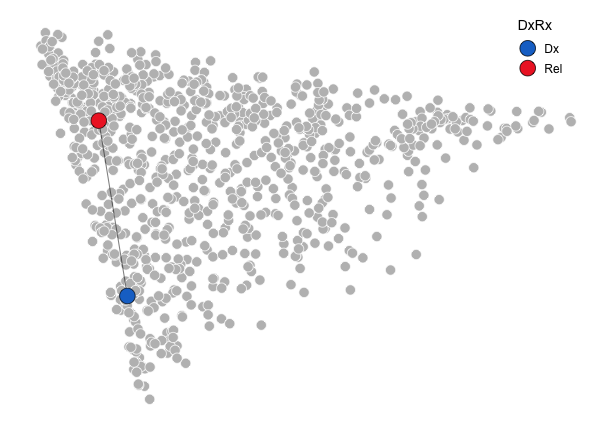

In [66]:
%%R -h 6 -w 8.5 --units in

combined_dxrx_merged %>% 
    ggplot(aes(x = PC1, y = PC2)) + 
    geom_point(data = subset(combined_dxrx_merged, DxRx == 'NA'), size=4.5, shape=21, fill ='grey', color='white') + 
    geom_path(data = subset(combined_dxrx_merged, Patient == '196371'), aes(group = Patient), alpha = 0.5) +#, arrow = arrow(type = "closed", length=unit(0.02, "npc"))) + 
    geom_point(data = subset(combined_dxrx_merged, Patient == '196371'), aes(fill = DxRx), size=7, shape=21, color='white') + 
    geom_point(data = subset(combined_dxrx_merged, Patient == '196371'), aes(fill = DxRx), size=7, shape=21, color='black') + 
    scale_fill_manual(values=c('dodgerblue3', 'firebrick2')) +
    theme_void() + 
    theme(legend.title = element_text(size = 14), 
          legend.text = element_text(size = 12), 
          legend.position = c(0.94, 0.99),
          legend.justification = c("right", 'top'),
          plot.margin = unit(c(1, 1, 1, 1), "lines")) #+ ggsave("figures/DxRx_All_Hierarchy_linked.png", dpi='retina', height=6, width=8.2)

R[write to console]: Using fishPlot version 0.5.1



[1] "WARNING: there were not 3 background gradient colors set - falling back to defaults"


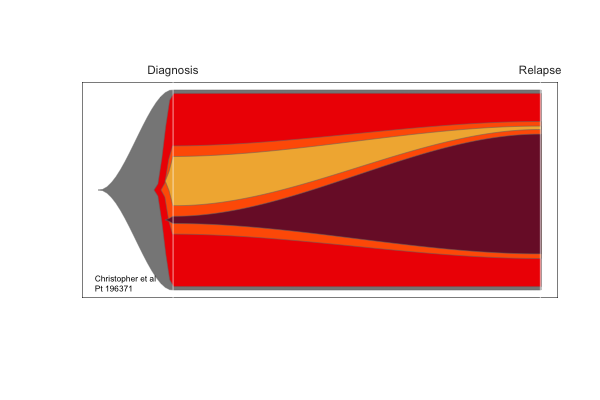

In [71]:
%%R -h 4 -w 6 --units in -r 100

library(rjson)
library(fishplot)

timepoints=c(1,2)      

# Values are from phyloWGS output
frac.table.CCF = matrix(
  c(100, 96.6, 44.1, 3.6, 24.6,
    100, 96.7, 68.5, 59.9, 1.7),
  ncol=length(timepoints))
parents = c(0,1,2,3,3)
fish = createFishObject(frac.table.CCF,parents,timepoints=timepoints)
fish = layoutClones(fish)
fish = setCol(fish,c("#888888", "#EF0000", "#FF6000", "#7B1732", "#F2B33F"))
fishPlot(fish,shape="spline", title.btm="Christopher et al\nPt 196371",
         cex.title=0.5, vlines=c(1,2),bg.type='solid', bg.col='white',
         vlab=c("Diagnosis", "Relapse"))

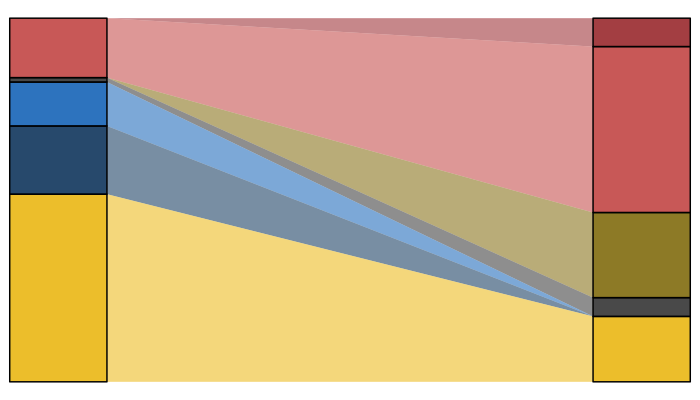

In [435]:
%%R -i dat -w 7 -h 4 --units in -r 100

library(ggalluvial)
library(scales)

hierarchy_colors = c('#A7303099', '#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')

populations = dat %>% 
    gather(-Patient, -DxRx, key = "Population", value = "prop") %>%
    mutate(Population = factor(Population, levels = c("LSPC-Quiescent", "LSPC-Primed", "LSPC-Cycle", 
                                                    "GMP-like", "ProMono-like", "Mono-like", "cDC-like"))) 

populations %>% 
    filter(Patient %in% c("196371")) %>%
    ggplot(.,
    aes(x = DxRx, y = prop, stratum = Population, alluvium = Population)) +
    geom_alluvium(aes(fill = Population), width = 1/6, alpha=0.9, knot.pos = 0) +
    geom_stratum(aes(fill = Population), width = 1/6, alpha=0.7) +
    scale_fill_manual(values = hierarchy_colors) + 
    scale_x_discrete(expand = c(.1, 0)) +
    theme_void() + 
    theme(legend.position='none')
    


In the patient above, the clonal replacement is mirrored by a replacement of mature cell types by LSPC populations (particularly Primed LSPC)

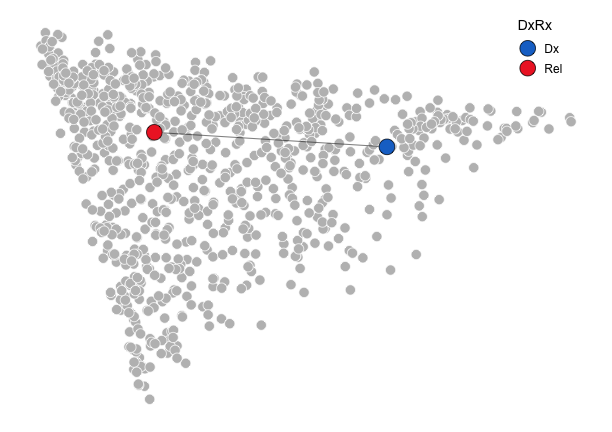

In [68]:
%%R -h 6 -w 8.5 --units in

combined_dxrx_merged %>% 
    ggplot(aes(x = PC1, y = PC2)) + 
    geom_point(data = subset(combined_dxrx_merged, DxRx == 'NA'), size=4.5, shape=21, fill ='grey', color='white') + 
    geom_path(data = subset(combined_dxrx_merged, Patient == '327733'), aes(group = Patient), alpha = 0.5) +#, arrow = arrow(type = "closed", length=unit(0.02, "npc"))) + 
    geom_point(data = subset(combined_dxrx_merged, Patient == '327733'), aes(fill = DxRx), size=7, shape=21, color='white') + 
    geom_point(data = subset(combined_dxrx_merged, Patient == '327733'), aes(fill = DxRx), size=7, shape=21, color='black') + 
    scale_fill_manual(values=c('dodgerblue3', 'firebrick2')) +
    theme_void() + 
    theme(legend.title = element_text(size = 14), 
          legend.text = element_text(size = 12), 
          legend.position = c(0.94, 0.99),
          legend.justification = c("right", 'top'),
          plot.margin = unit(c(1, 1, 1, 1), "lines")) #+ ggsave("figures/DxRx_All_Hierarchy_linked.png", dpi='retina', height=6, width=8.2)

[1] "WARNING: there were not 3 background gradient colors set - falling back to defaults"


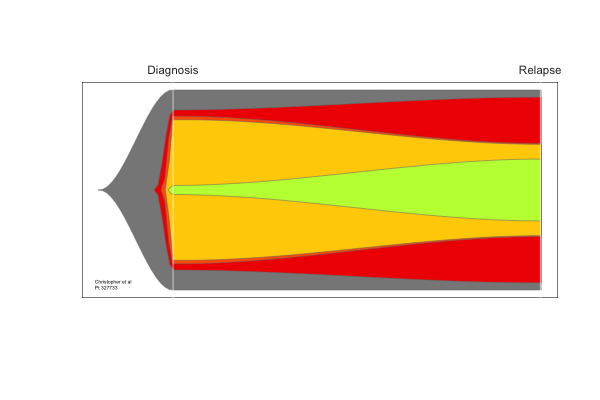

In [72]:
%%R -h 4 -w 6 --units in -r 100

frac.table.CCF = matrix(
  c(100, 80, 73.8, 70.2, 4.5,
    100, 92.8, 46.6, 45.7, 30.9),
  ncol=length(timepoints))
parents = c(0,1,2,3,4)
fish = createFishObject(frac.table.CCF,parents,timepoints=timepoints)
fish = layoutClones(fish)

fishPlot(fish,shape="spline", title.btm="Christopher et al\nPt 327733",
         cex.title=0.3, vlines=c(1,2),bg.type='solid', bg.col='white',
         vlab=c("Diagnosis","Relapse"))

R[write to console]: 
Attaching package: ‘scales’


R[write to console]: The following object is masked from ‘package:purrr’:

    discard


R[write to console]: The following object is masked from ‘package:readr’:

    col_factor




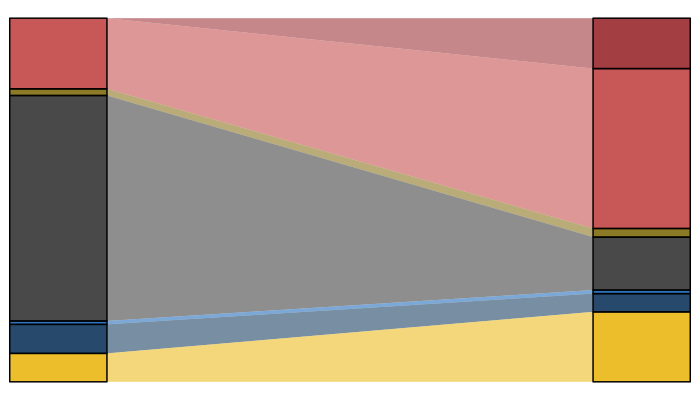

In [70]:
%%R -i dat -w 7 -h 4 --units in -r 100

library(ggalluvial)
library(scales)

hierarchy_colors = c('#A7303099', '#CD534C99', '#8F770099', '#3B3B3B99', '#0073C299', '#003C6799', '#EFC00099')

populations = dat %>% 
    gather(-Patient, -DxRx, key = "Population", value = "prop") %>%
    mutate(Population = factor(Population, levels = c("LSPC-Quiescent", "LSPC-Primed", "LSPC-Cycle", 
                                                    "GMP-like", "ProMono-like", "Mono-like", "cDC-like"))) 

populations %>% 
    filter(Patient %in% c("327733")) %>%
    ggplot(.,
    aes(x = DxRx, y = prop, stratum = Population, alluvium = Population)) +
    geom_alluvium(aes(fill = Population), width = 1/6, alpha=0.9, knot.pos = 0) +
    geom_stratum(aes(fill = Population), width = 1/6, alpha=0.7) +
    scale_fill_manual(values = hierarchy_colors) + 
    scale_x_discrete(expand = c(.1, 0)) +
    theme_void() + 
    theme(legend.position='none')
    


In this patient, there is no clear clonal evolution (one clone mildly expands but does not carry a known driver), but there is an extensive change in cell-type composition wherein the GMP-like population becomes replaced by Quiescent and Primed LSPCs. 